# PLSI for Analyzing Twitter Stream

## 1. twitter.mat holds two Term-Frequency (TF) matrices Xtr and Xte. It also contains YtrMat and YteMat, the target variables in the one-hot vector format.

In [38]:
mat = scipy.io.loadmat('data/twitter.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sat Apr  8 02:28:48 2017',
 '__version__': '1.0',
 '__globals__': [],
 'Xte': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'Xtr': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'YteMat': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         1,

## 2. Each column of the TF matrix Xtr can be either “positive”, “negative”, or “neutral”, which are represented numerically as 1, 2, and 3 in the YtrMat. They are sentimental classes of the original twits.

In [39]:
# Extracting training and testing data from twitter.mat
X_train = mat['Xtr']
Y_train_M = mat['YtrMat']

X_test = mat['Xte']
Y_test_M = mat['YteMat']

## 3. Learn 50 PLSI topics B ∈ R891×50 and their weights Θtr ∈ R50×773 from the training data Xtr, using the ordinary PLSI update rules.

In [40]:
# initialize random topics
B = np.random.randn(891, 50)

# initialize random weights
O = np.random.randn(50, 773)

In [41]:
def get_d(B, O):
    d = np.dot(B, O)
    d[d == 0] = 0.0001
    return d

In [42]:
def update_topics(B, O, X, d):
    B = B * np.dot((X/d), O.T)
    B = B / np.dot(np.ones([B.shape[0], B.shape[0]]), B)
    return B

In [43]:
def update_weights(B, O, X, d):   
    O = O * np.dot(B.T, (X/d))
    O = O / np.dot(np.ones([O.shape[0], O.shape[0]]), O)
    return O

In [44]:
for i in range(500):
    d = get_d(B, O)
    B = update_topics(B, O, X_train, d)

    d = get_d(B, O)
    O = update_weights(B, O, X_train, d)

## 4. Reduce the dimension of Xte down to 50, by learning the weight matrix Θte ∈ R50×193. This can be done by doing another PLSI on the test data Xte, but this time by reusing the topic matrix B you learned from the training set. So, you skip the update rule for B. You only update Θte ∈ R50×193.

In [45]:
O_new = np.random.rand(50,193)

for i in range(500):
    d = get_d(B, O_new)
    update_weights(B, O_new, X_test, d)

In [46]:
lr = 0.005

W = np.random.uniform(0, 5, (3, O.shape[0]))
b = np.random.uniform(0, 5, (3,1))
error_list = []

## 5. Define a perceptron layer for the softmax classification. This part is similar to the case with kernel PCA with a perceptron as you did in Homework #5. Instead of the kernel PCA results as the input to the perceptron, you use Θtr for training, and Θte for testing. This time the number of output units is 3 as there are three classes, and that’s why the target variable YtrMat is with three elements. Review M6 S37-39 to review what softmax is.

In [47]:
def softmax(W, O, b):
    Y_cap = np.exp(np.dot(W, O) + b)
    Y_cap = Y_cap / np.sum(Y_cap, axis=0).reshape(1,-1)
    return Y_cap

In [48]:
def update_weights(X, lr, delta_X):
    X = X - (lr * delta_X)
    return X

In [49]:
for i in range(1000):
    Y_cap = softmax(W, O, b)
    
    diff = Y_cap - Y_train_M
    delta_w = np.dot(diff, O.T)
    delta_b = np.dot(diff, np.ones([Y_train_M.shape[1],1]))
    
    W = update_weights(W, lr, delta_w)
    B = update_weights(b, lr, delta_b)
        
    error = -np.sum(Y_train_M * np.log(Y_cap))
    error_list.append(error)

## 6. Report your classification accuracy.

In [50]:
def scores(Y_cap, Y):
    match_count = np.sum(np.argmax(Y_cap, axis=0) == np.argmax(Y, axis=0))
    score = match_count / Y.shape[1]
    return score

In [51]:
Y_cap_test = softmax(W, O_new, b)

train_score = scores(Y_cap, Y_train_M)
test_score = scores(Y_cap_test, Y_test_M)

In [52]:
print('Training accuracy is: ' + str(train_score))
print('Testing accuracy is: ' + str(test_score))

Training accuracy is: 0.6351875808538163
Testing accuracy is: 0.5440414507772021


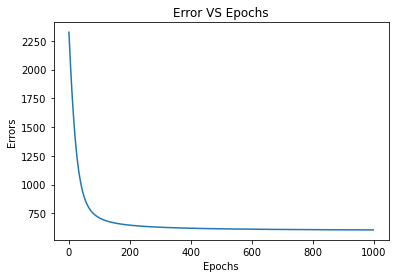

In [53]:
plt.title('Error VS Epochs')
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.plot(error_list)
plt.show()